In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
def det3(a, b, c):
    return (a[0]*b[1] + b[0]*c[1] + c[0]*a[1]) - (c[0]*b[1] + b[0]*a[1] + a[0]*c[1])
    
def orient(a, b, c, e=1e-12):
    d = det3(a, b, c)
    if d > e:
        return 1
    if d < -e:
        return -1
    else:
        return 0
    
class Tr:
    def __init__(self, a, b, c, neigh = []):
        # a,b,c counterclockwise
        self.a = a
        self.b = b
        self.c = c
        
        self.neigh = neigh
        self.child = []
        
    def find_neigh(self, a, b):
        '''
        return neighboring triangle through ab
        '''
        for n, p1, p2 in self.neigh:
            if (p1 == a).all() and (p2 == b).all():
                return (n,p1,p2)
            elif (p2 == a).all() and (p1 == b).all():
                return (n,p1,p2)
        return (None, None, None)
            
    def replace_neigh(self, nold, nnew):
        '''
        replace neighbours from nold to nnew
        '''
        k = -1
        pk1 = pk2 = None
        for i,(n,p1,p2) in enumerate(self.neigh):
            if n == nold:
                k = i
                pk1 = p1
                pk2 = p2
                break
        self.neigh[k] = (nnew, pk1, pk2)
            
    def find_point(self, line):
        '''
        return point not lying on line
        '''
        if not (self.a == line[0]).all() and not (self.a == line[1]).all():
            return self.a
        if not (self.b == line[0]).all() and not (self.b == line[1]).all():
            return self.b
        if not (self.c == line[0]).all() and not (self.c == line[1]).all():
            return self.c
        
    def circumcircle(self):
        '''
        return midpoint and radius of circumcircle
        '''
        a = self.a[0]**2 + self.a[1]**2
        b = self.b[0]**2 + self.b[1]**2
        c = self.c[0]**2 + self.c[1]**2
        
        t = det3(self.a, self.b, self.c)
        
        sx = (1/2) * det3([a, self.a[1]],[b, self.b[1]], [c, self.c[1]]) / t
        sy = (1/2) * det3([self.a[0], a],[self.b[0], b], [self.c[0], c]) / t
        s = np.array([sx, sy])
        
        return (s, np.linalg.norm(s-self.a))
            
    def legalize(self, pr, pi, pj, nn):
        '''
        pr - newly added point
        pi, pj - edge to check
        nn - neighboring triangle through pi,pj
        '''
        pk = nn.find_point([pi, pj])
        s, r = self.circumcircle()
        
        if np.linalg.norm(pk-s) <= r:
            f1 = Tr(pr, pi, pk)
            f2 = Tr(pr, pk, pj)
            
            f1n1 = self.find_neigh(pr, pi)[0]
            f1n2 = nn.find_neigh(pi, pk)[0]
            f1.neigh = [(f1n1, pr, pi), (f1n2, pi, pk), (f2, pk, pr)]
            if f1n1 is not None:
                f1n1.replace_neigh(self, f1)
            if f1n2 is not None:
                f1n2.replace_neigh(nn, f1)
            
            f2n1 = self.find_neigh(pj, pr)[0]
            f2n2 = nn.find_neigh(pk, pj)[0]
            f2.neigh = [(f2n1, pj, pr), (f2n2, pk, pj), (f1, pr, pk)]
            if f2n1 is not None:
                f2n1.replace_neigh(self, f2)
            if f2n2 is not None:
                f2n2.replace_neigh(nn, f2)
            
            self.child = [f1, f2]
            nn.child = [f1, f2]
            
            if f1n2 is not None:
                f1.legalize(pr, pi, pk, f1n2)
            if f2n2 is not None:
                f2.legalize(pr, pk, pj, f2n2)
        
    def add_inside(self, p):
        n1 = Tr(self.a, self.b, p)
        n2 = Tr(self.b, self.c, p)
        n3 = Tr(self.c, self.a, p)
        
        m, p1, p2 = self.find_neigh(self.a, self.b)
        n1.neigh = [(m, n1.a, n1.b), (n2, n1.b, n1.c), (n3, n1.c, n1.a)]
        if m is not None:
            m.replace_neigh(self, n1)
        
        m, p1, p2 = self.find_neigh(self.b, self.c)
        n2.neigh = [(m, n2.a, n2.b), (n3, n2.b, n2.c), (n1, n2.c, n2.a)]
        if m is not None:
            m.replace_neigh(self, n2)
        
        m, p1, p2 = self.find_neigh(self.c, self.a)
        n3.neigh = [(m, n3.a, n3.b), (n1, n3.b, n3.c), (n2, n3.c, n3.a)]
        if m is not None:
            m.replace_neigh(self, n3)   
        
        self.child = [n1, n2, n3]
        
        if n1.neigh[0][0] is not None:
            n1.legalize(p, self.a, self.b, n1.neigh[0][0])
        if n2.neigh[0][0] is not None:
            n2.legalize(p, self.b, self.c, n2.neigh[0][0])
        if n3.neigh[0][0] is not None:
            n3.legalize(p, self.c, self.a, n3.neigh[0][0])
            
    def find_edge(self, p):
        if orient(self.a, self.b, p) == 0:
            return self.a, self.b, self.c
        if orient(self.b, self.c, point) == 0:
            return self.b, self.c, self.a
        if orient(self.c, self.a, point) == 0:
            return self.c, self.a, self.b
            
    def split(self, p):
        pi, pj, pk1 = self.find_edge(p)
        n = self.find_neigh(pi, pj)
        pk2 = n.find_point([pi, pj])
        
        f1 = Tr(p, pk2, pj)
        f2 = Tr(p, pi, pk2)
        f3 = Tr(p, pk1, pi)
        f4 = Tr(p, pj, pk1)
        
        m1, p1, p2 = n.find_neigh(pk2, pj)
        f1.neigh = [(f2, p, pk2), (f4, pj, p), (m1, pk2, pj)]
        if m1 is not None:
            m1.replace_neigh(n, f1)
            
        m2, p1, p2 = n.find_neigh(pi, pk2)
        f2.neigh = [(f1, pk2, p), (f3, p, pi), (m2, pi, pk2)]
        if m2 is not None:
            m2.replace_neigh(n, f2)
            
        m3, p1, p2 = self.find_neigh(pk1, pi)
        f3.neigh = [(f2, pi, p), (f4, p, pk1), (m3, pk1, pi)]
        if m3 is not None:
            m3.replace_neigh(self, f3)
            
        m4, p1, p2 = self.find_neigh(pj, pk1)
        f4.neigh = [(f3, pk1, p), (f1, p, pj), (m4, pj, pk1)]
        if m4 is not None:
            m4.replace_neigh(self, f4)
            
        n.child = [f1, f2]
        self.child = [f3, f4]
        
        f1.legalize(p, pk2, pj, f1, m1)
        f2.legalize(p, pi, pk2, f2, m2)
        f3.legalize(p, pk1, pi, f3, m3)
        f4.legalize(p, pj, pk1, f4, m4)
            
    def is_inside(self, point):
        d1 = orient(self.a, self.b, point)
        d2 = orient(self.b, self.c, point)
        d3 = orient(self.c, self.a, point)
        return d1 > 0 and d2 > 0 and d3 > 0
        
    def find(self, point):
        for child in self.child:
            d1 = orient(child.a, child.b, point)
            d2 = orient(child.b, child.c, point)
            d3 = orient(child.c, child.a, point)
            if d1 >= 0 and  d2 >= 0 and d3 >= 0:
                return child.find(point)
        return self
    
    def __eq__(self, other):
        if other is None:
            return False
        return ((self.a == other.a).all() and (self.b == other.b).all() and (self.c == other.c).all()) or \
                ((self.a == other.b).all() and (self.b == other.c).all() and (self.c == other.a).all()) or \
                ((self.a == other.c).all() and (self.b == other.a).all() and (self.c == other.b).all())
    
    def __hash__(self):
        return hash((tuple(self.a.tolist()), tuple(self.b.tolist()), tuple(self.c.tolist())))
    
    def __str__(self):
        return "{" + str(self.a) + "," + str(self.b)+ "," + str(self.c) + "}"
    
    def __repr__(self):
        return "{" + str(self.a) + "," + str(self.b)+ "," + str(self.c) + "}"

In [3]:
def triangulate(points):
    points = np.random.permutation(points)
    root = Tr(np.array([0, 1000]), np.array([-1000, -1000]), np.array([1000, -1000]))
    
    for p in points:
        n = root.find(p)
        
        if n.is_inside(p):
            n.add_inside(p)
        else:
            print("split")
            n.split(p)
    
    return root

In [4]:
def get_leafs(root):
    res = set()
    
    if len(root.child) == 0:
        return {root}
    
    for c in root.child:
        res = res | get_leafs(c)
        
    return res

In [5]:
pts = np.random.uniform(-100, 100, size=(20, 2))
res = triangulate(pts)

<IPython.core.display.Javascript object>


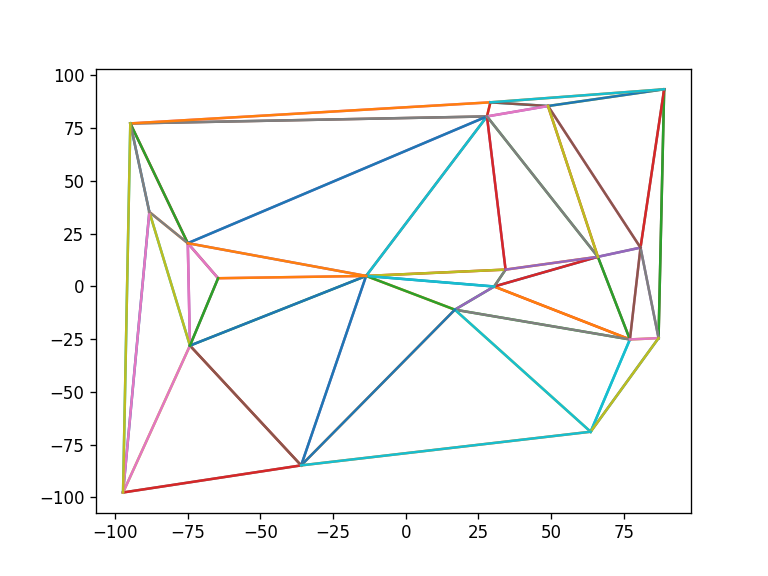

In [6]:
for l in get_leafs(res):
    if not abs(l.a[0]) > 100 and not abs(l.a[1]) > 100 and not abs(l.b[0]) > 100 and not abs(l.b[1]) > 100:
        plt.plot([l.a[0], l.b[0]], [l.a[1], l.b[1]])
    if not abs(l.b[0]) > 100 and not abs(l.b[1]) > 100 and not abs(l.c[0]) > 100 and not abs(l.c[1]) > 100:
        plt.plot([l.b[0], l.c[0]], [l.b[1], l.c[1]])
    if not abs(l.c[0]) > 100 and not abs(l.c[1]) > 100 and not abs(l.a[0]) > 100 and not abs(l.a[1]) > 100:
        plt.plot([l.c[0], l.a[0]], [l.c[1], l.a[1]])